# CSC 3105 Project

# Load and Clean the Data

This code block performs the following operations:

1. Imports necessary libraries for data handling and cleaning.
2. Defines a function `load_data` to load the data from a given directory into a pandas dataframe.
3. Defines a function `clean_data` to clean the loaded data. The cleaning process includes:
   - Handling missing values by dropping them.
   - Removing duplicate rows.
   - Converting the 'NLOS' column to integer data type.
   - Normalizing the 'Measured range (time of flight)' column.
   - Creating new features 'FP_SUM' and 'SNR'.
   - One-hot encoding categorical features.
   - Performing feature extraction on 'CIR' columns.
   - Dropping the original 'CIR' columns.
   - Checking for columns with only one unique value and dropping them.
4. Checks if a pickle file with the cleaned data exists. If it does, it loads the data from the file. If it doesn't, it loads and cleans the data using the defined functions.
5. Prints the first few rows of the cleaned data and its column headers.

In [77]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pywt
from skimage import restoration
from tensorflow.keras.utils import to_categorical


In [78]:
# Define the directory where the dataset is located
DATASET_DIR = './UWB-LOS-NLOS-Data-Set/dataset'

def load_data(dataset_dir):
    # Load the data
    # file_paths = [os.path.join(dirpath, file) for dirpath, _, filenames in os.walk(dataset_dir) for file in filenames if 'uwb_dataset_part7.csv' not in file]
    file_paths = [os.path.join(dirpath, file) for dirpath, _, filenames in os.walk(dataset_dir) for file in filenames]
    data = pd.concat((pd.read_csv(file_path) for file_path in file_paths))
    print(f"Original data shape: {data.shape}")
    return data


In [79]:
def stat_analysis_and_plots(data):
    # Statistical Analysis
    print("Statistical Analysis:")
    print(data.describe())

    # Plot Boxplot to check for outliers for the first 15 columns
    print("Boxplot of the first 15 columns:")
    fig, axs = plt.subplots(15,1,dpi=95, figsize=(7,17))
    for i, col in enumerate(data.columns[:15]):
        axs[i].boxplot(data[col], vert=False)
        axs[i].set_ylabel(col)
    plt.show()


# Channel Impulse Response (CIR) Graphs

This code block defines a function `cir_graphs` to plot the Channel Impulse Response (CIR) for Line of Sight (LOS) and Non-Line of Sight (NLOS) data. The CIR is a sequence of values representing the channel response to a single impulse. It is used to characterize the channel in wireless communication systems.

In [80]:
def cir_graphs(data):
    # Separate the data into LOS and NLOS
    data_los = data[data['NLOS'] == 0]
    data_nlos = data[data['NLOS'] == 1]

    # Extract the CIR columns
    cir_columns = [col for col in data.columns if 'CIR' in col]
    data_los_cir = data_los[cir_columns]
    data_nlos_cir = data_nlos[cir_columns]

    # Calculate the magnitude and time for each CIR column
    time_los = np.arange(len(data_los_cir.columns))
    magnitude_los = np.linalg.norm(data_los_cir.values, axis=0)

    time_nlos = np.arange(len(data_nlos_cir.columns))
    magnitude_nlos = np.linalg.norm(data_nlos_cir.values, axis=0)

    # Plot the magnitude vs time for LOS
    plt.figure(figsize=(20, 10), dpi=300)  # Increase figure size and DPI
    plt.plot(time_los, magnitude_los, linewidth=2)  # Increase line width
    plt.title('Magnitude vs Time for LOS')
    plt.xlabel('Time (ns)')
    plt.ylabel('Magnitude')
    plt.xlim([600, max(time_los)])  # Set x-axis limits
    plt.ylim([0, 2e6])
    plt.show()

    # Plot the magnitude vs time for NLOS
    plt.figure(figsize=(20, 10), dpi=300)  # Increase figure size and DPI
    plt.plot(time_nlos, magnitude_nlos, linewidth=2)  # Increase line width
    plt.title('Magnitude vs Time for NLOS')
    plt.xlabel('Time (ns)')
    plt.ylabel('Magnitude')
    plt.xlim([600, max(time_los)])  # Set x-axis limits
    plt.ylim([0, 2e6])
    plt.show()
    

# Signal to Noise Ratio (SNR) Graph

This code block defines a function `snr_graph` to plot the Signal to Noise Ratio (SNR) for Line of Sight (LOS) and Non-Line of Sight (NLOS) data. The SNR is calculated as the ratio of the 'CIR_PWR' to the 'STDEV_NOISE' for each data point.

In [81]:

def snr_graph(data):
    # Separate the data into LOS and NLOS
    data_los = data[data['NLOS'] == 0]
    data_nlos = data[data['NLOS'] == 1]

    # Extract the SNR values
    snr_los = data_los['SNR']
    snr_nlos = data_nlos['SNR']

    # Create a new figure
    plt.figure(figsize=(10, 5))

    # Plot SNR for LOS
    plt.plot(snr_los, label='LOS')

    # Plot SNR for NLOS
    plt.plot(snr_nlos, color='red', label='NLOS')

    # Set title and labels
    plt.title('SNR for LOS and NLOS')
    plt.xlabel('Index')
    plt.ylabel('SNR')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()
    

# Scatter Plot of RX_Level and First_Path_Power_Level

In [82]:
def plot_features(data, labels, feature1, feature2):
    reds = labels == 1
    blacks = labels == 0
    plt.scatter(data[reds][feature1], data[reds][feature2], c="red", s=20, edgecolor='k')
    plt.scatter(data[blacks][feature1], data[blacks][feature2], c="yellow", s=20, edgecolor='k')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f"Plot of data: {feature1} versus {feature2}")
    plt.show()

## denoise_cir Function

The `denoise_cir` function uses the Discrete Wavelet Transform (DWT) to denoise the Channel Impulse Response (CIR) values. The DWT is a linear transformation that operates on a data vector whose length is an integer power of two, transforming it into a numerically different vector of the same length. The DWT of a signal `x` is calculated as follows:

1. **Wavelet Decomposition:**

    The input signal `x` is passed through two complementary filters and emerges as two signals. The filter outputs are decimated by 2 (down-sampled) to get the approximation coefficients (cA) and detail coefficients (cD).

    The approximation coefficients represent the high-scale, low-frequency component of the signal, while the detail coefficients represent the low-scale, high-frequency component.

2. **Thresholding:**

    The detail coefficients are thresholded to remove noise. The thresholding function `T` applied to the detail coefficients `x` is defined as:
$$
T(x) = x * I(|x| > \text{{value}}) \quad \text{{for 'hard' thresholding}}
$$

$$
T(x) = \text{{sign}}(x)(|x| - \text{{value}})_+ \quad \text{{for 'soft' thresholding}}
$$

where $I$ is the indicator function that is one if the argument is true and zero otherwise, $\text{{value}}$ is the threshold value, and $(x)_+$ equals $x$ if $x > 0$ and zero otherwise.

3. **Wavelet Reconstruction:**

    The original signal is reconstructed from the approximation and detail coefficients.

In [83]:
def denoise_cir(cir_values, wavelet='db1', level=1):
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(cir_values, wavelet, level=level)

    # Set the detail coefficients to zero
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], value=0.5, mode='soft')

    # Perform wavelet reconstruction
    denoised_cir = pywt.waverec(coeffs, wavelet)

    return denoised_cir


## deconvolve_cir Function

The `deconvolve_cir` function applies the Richardson-Lucy deconvolution algorithm to deconvolve the Channel Impulse Response (CIR) values. 

In the context of signal processing, deconvolution is the process of reversing the effects of convolution on a signal. Convolution is a mathematical operation that blends two functions together and is often used to describe the effect of a linear time-invariant system on a signal. Deconvolution, therefore, attempts to recover the original signal that was convolved with the system's impulse response to produce the current signal.

The Richardson-Lucy algorithm is an iterative method for deconvolution. It is particularly suitable for cases where the impulse response of the system (also known as the Point Spread Function, or PSF) is known, and the noise is Poissonian (such as in astronomical images). 

The algorithm works by iteratively refining an estimate of the original signal. In each iteration, it performs a prediction step where it convolves the current estimate with the PSF to predict the observed signal, and a correction step where it computes the ratio of the observed signal to the predicted signal, convolves this ratio with the PSF, and multiplies the result with the current estimate to get the next estimate.

This process is repeated for a fixed number of iterations, or until the estimate converges to a stable solution. The result is a denoised estimate of the original signal.

The mathematical formulas involved in the Richardson-Lucy deconvolution algorithm are as follows:

1. **Prediction Step:**

    The current estimate of the latent image `x` is convolved with the PSF `h` to predict the observed image `y`. This can be represented as:

    $$
    y = h \ast x
    $$

    where $\ast$ denotes the convolution operation.

2. **Correction Step:**

The ratio of the observed image $y$ to the predicted image $y'$ is computed, then the PSF $h$ is convolved with this ratio and multiplied with the current estimate $x$ to get the next estimate $x'$. This can be represented as:

$$
x' = x \cdot (h \ast \left(\frac{y}{y'}\right))
$$

where $\div$ denotes element-wise division and $\ast$ denotes the convolution operation.


In [84]:

def deconvolve_cir(cir_values, psf=None, iterations=50):
    # If no point spread function is provided, create a simple one
    if psf is None:
        psf = np.ones((5,)) / 5

    # Perform Richardson-Lucy deconvolution
    deconvolved_cir = restoration.richardson_lucy(cir_values, psf, num_iter=iterations)

    return deconvolved_cir

In [85]:

def clean_data(data):
    print("Starting data cleaning process...")
    
    # print("Before Cleaning")
    # stat_analysis_and_plots(data)

    # Calculate total number of missing values in the data
    total_missing = data.isnull().sum().sum()
    print(f"Total number of missing values: {total_missing}")

    # Data has no missing values
    data = data.dropna()
    print("Missing values dropped.")

    # Data has no duplicate rows
    data = data.drop_duplicates()
    print("Duplicate rows dropped.")

    # Convert 'NLOS' column to integer data type (0 for LOS, 1 for NLOS)
    data['NLOS'] = data['NLOS'].astype(int)
    print("'NLOS' column converted to integer data type.")
    
    # Print line where CIR_PWR is 0
    print(f"Line where CIR_PWR is 0: {data[data['CIR_PWR'] == 0]}")
    
    # Calculate the expression inside the log10 function
    expression = (data['CIR_PWR'] * (2**17)) / (data['RXPACC']**2)

    # If the expression is 0, set 'RX_Level' to 0
    zero_indices = expression == 0
    data.loc[zero_indices, 'RX_Level'] = 0

    # For the rest of the data where the expression is not 0, calculate 'RX_Level'
    # First, update the 'expression' and 'data' to exclude zero_indices
    expression = expression.loc[~zero_indices]
    data = data.loc[~zero_indices]

    # Now, calculate 'RX_Level' for the rest of the data
    data['RX_Level'] = 10 * np.log10(expression) - data['PRFR']

    # Calculate the median of 'RX_Level'
    median = data['RX_Level'].median()

    # Create the boolean mask on the same DataFrame 'data'
    zero_indices = (data['RX_Level'] == 0)

    # Replace zero values in 'RX_Level' with the median
    data.loc[zero_indices, 'RX_Level'] = median

    print("New feature 'RX_Level' created.")

    # Calculate new feature 'First_Path_Power_Level'
    data['First_Path_Power_Level'] = (10 * np.log10(
        (data['FP_AMP1'] ** 2 + data['FP_AMP2'] ** 2 + data['FP_AMP3'] ** 2) / (data['RXPACC'] ** 2))) - 64
    print("New feature 'First_Path_Power_Level' calculated.")
    data.drop(['FP_AMP1', 'FP_AMP2', 'FP_AMP3', 'RXPACC', 'PRFR'], axis=1, inplace=True)

    # Calculate SNR as the ratio of 'CIR_PWR' to 'STDEV_NOISE' for each data point
    data['SNR'] = data['CIR_PWR'] / data['STDEV_NOISE']
    print("New feature 'SNR' created.")
    data.drop(['CIR_PWR', 'STDEV_NOISE'], axis=1, inplace=True)

    # One-hot encode categorical features
    categorical_features = ['CH', 'FRAME_LEN', 'PREAM_LEN', 'BITRATE']
    encoder = LabelEncoder()
    for feature in categorical_features:
        data[feature] = encoder.fit_transform(data[feature])
    print("Categorical features one-hot encoded.")

    # Extract the 'CIR' columns
    cir_columns = [col for col in data.columns if 'CIR' in col]
    cir_data = data[cir_columns]    
    print("'CIR' columns extracted.")
    
    # Convert 'CIR' columns to float
    cir_data = cir_data.astype(float)
    print("'CIR' columns converted to float.")
    
    # Denoise 'CIR' columns
    denoised_cir_data = cir_data.apply(denoise_cir)
    # denoised_cir_data = cir_data.apply(deconvolve_cir)
    print("'CIR' columns denoised.")
    
    # Replace original 'CIR' columns with denoised data
    data[cir_columns] = denoised_cir_data
    print("Original 'CIR' columns replaced with denoised data.")
    
    # Extract the 'CIR' columns
    # cir_columns = [f"CIR{i}" for i in range(1015)]
    # # cir_columns = [f"CIR{i}" for i in range(1016)]
    # cir_data = data[cir_columns]
    # print("'CIR' columns extracted.")
    # 
    # # Perform PCA on the 'CIR' columns
    # pca = PCA(n_components=0.95)
    # cir_pca = pca.fit_transform(cir_data)
    # print("PCA performed on 'CIR' columns.")
    # 
    # # Create a DataFrame with the principal components
    # cir_pca_df = pd.DataFrame(cir_pca, columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)])
    # print("DataFrame with principal components created.")
    # 
    # # Drop the original 'CIR' columns from the data
    # data = data.drop(columns=cir_columns)
    # print("Original 'CIR' columns dropped.")

    # Add the principal components to the original data
    # Reset the index of both dataframes
    # data = data.reset_index(drop=True)
    # cir_pca_df = cir_pca_df.reset_index(drop=True)
    # print("Indexes of both dataframes reset.")

    # Concatenate the dataframes
    # data = pd.concat([data, cir_pca_df], axis=1)
    # print("Dataframes concatenated.")

    # List of columns to check for unique values
    columns_to_check = ['CH', 'PREAM_LEN', 'BITRATE']

    # Iterate over the columns
    for column in columns_to_check:
        # If the column has only one unique value, drop it
        if data[column].nunique() == 1:
            data = data.drop(column, axis=1)
            print(f"Column '{column}' dropped due to having only one unique value.")

    # Standardize the numerical columns (excluding 'NLOS')
    # numerical_cols = data.select_dtypes(include=[np.number]).columns
    # numerical_cols = numerical_cols.drop('NLOS')
    # scaler = StandardScaler()
    # data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
    # print("Numerical columns standardized.")

    # Print the shape of the cleaned data
    print(f"Cleaned data shape: {data.shape}")

    # print("After Cleaning")
    # stat_analysis_and_plots(data)
    
    print("Data cleaning process completed.")
    
    # Return the cleaned data
    return data

Loading data from pickle file...


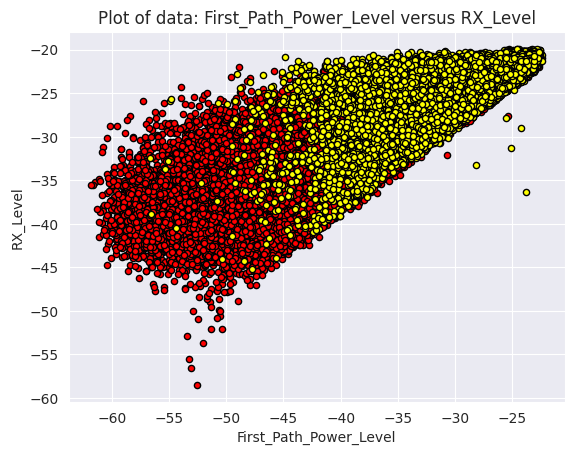

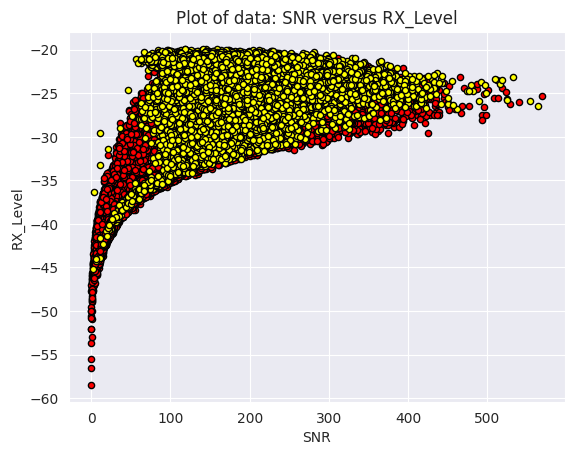

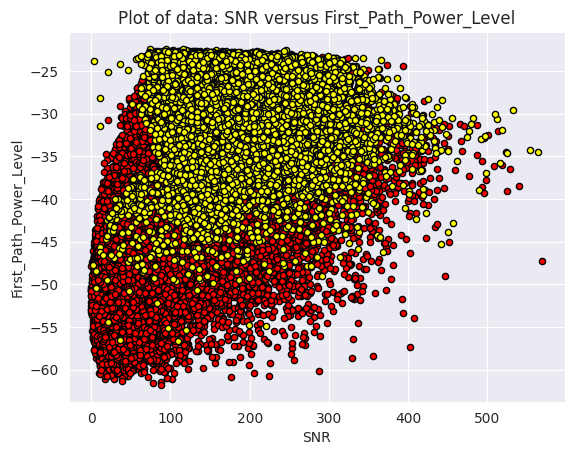

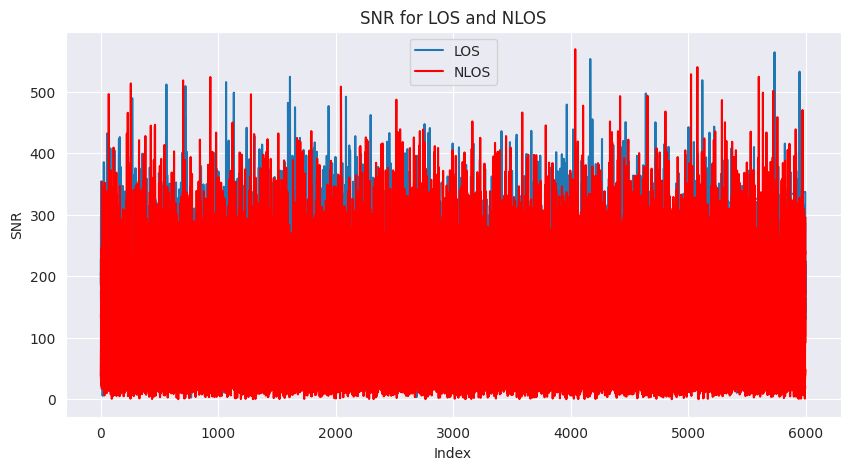

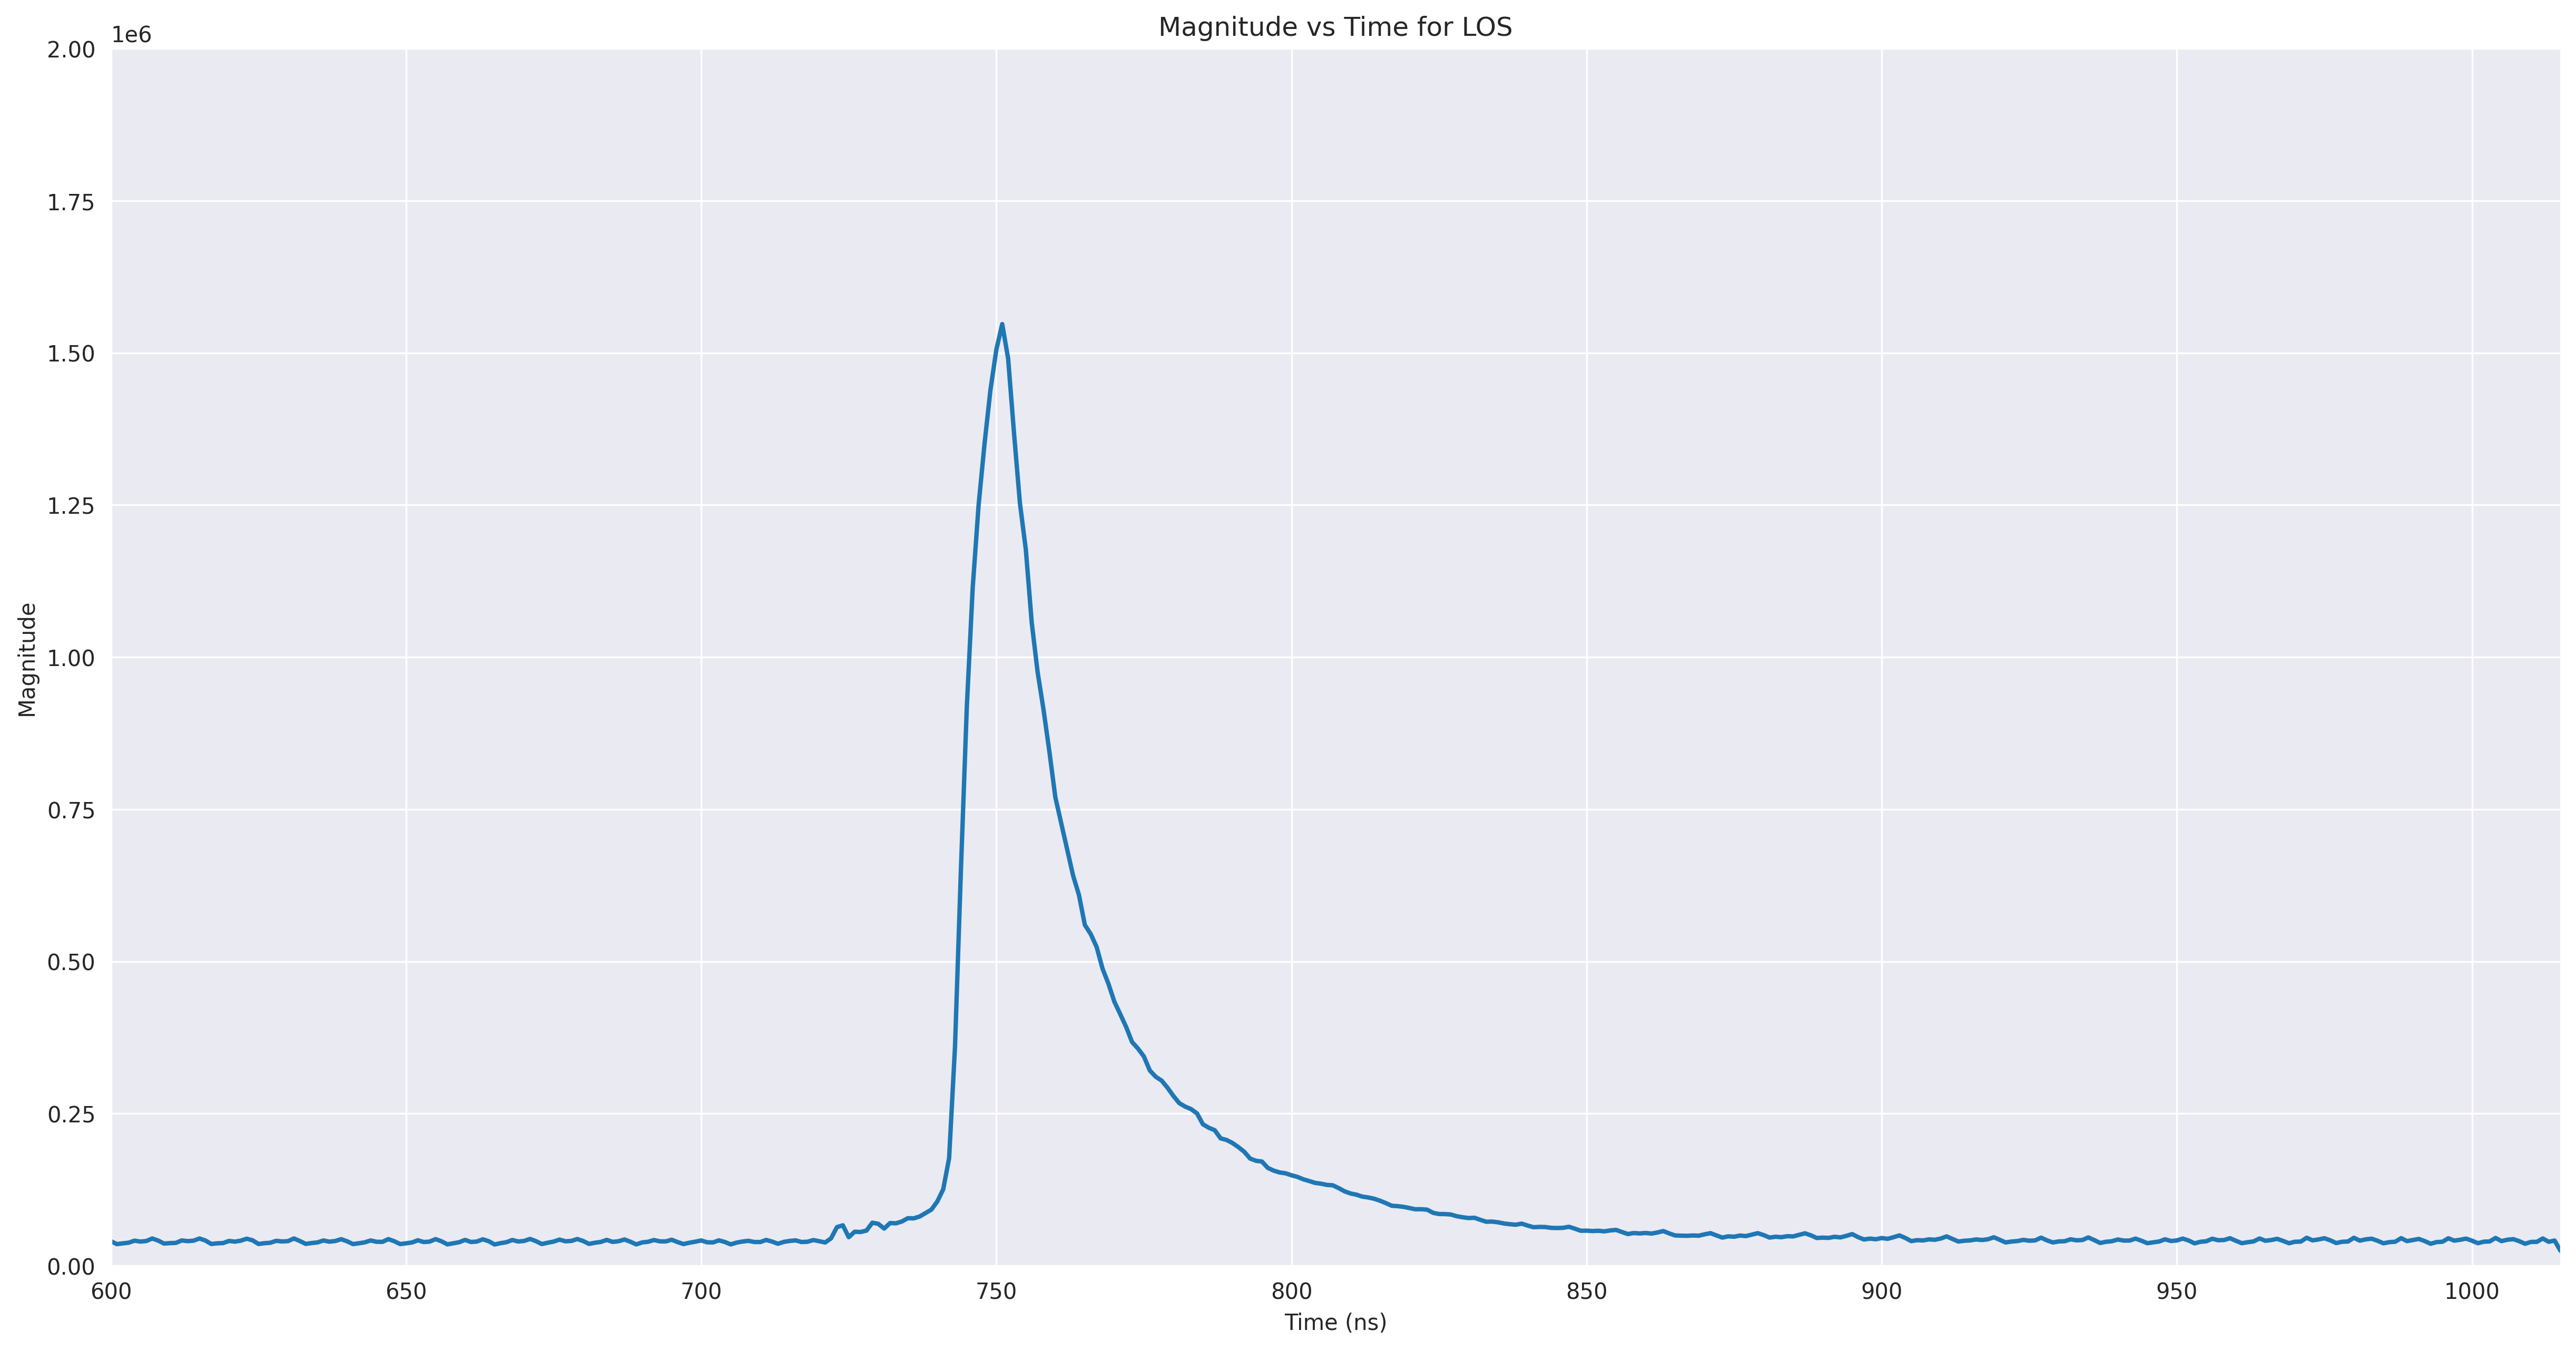

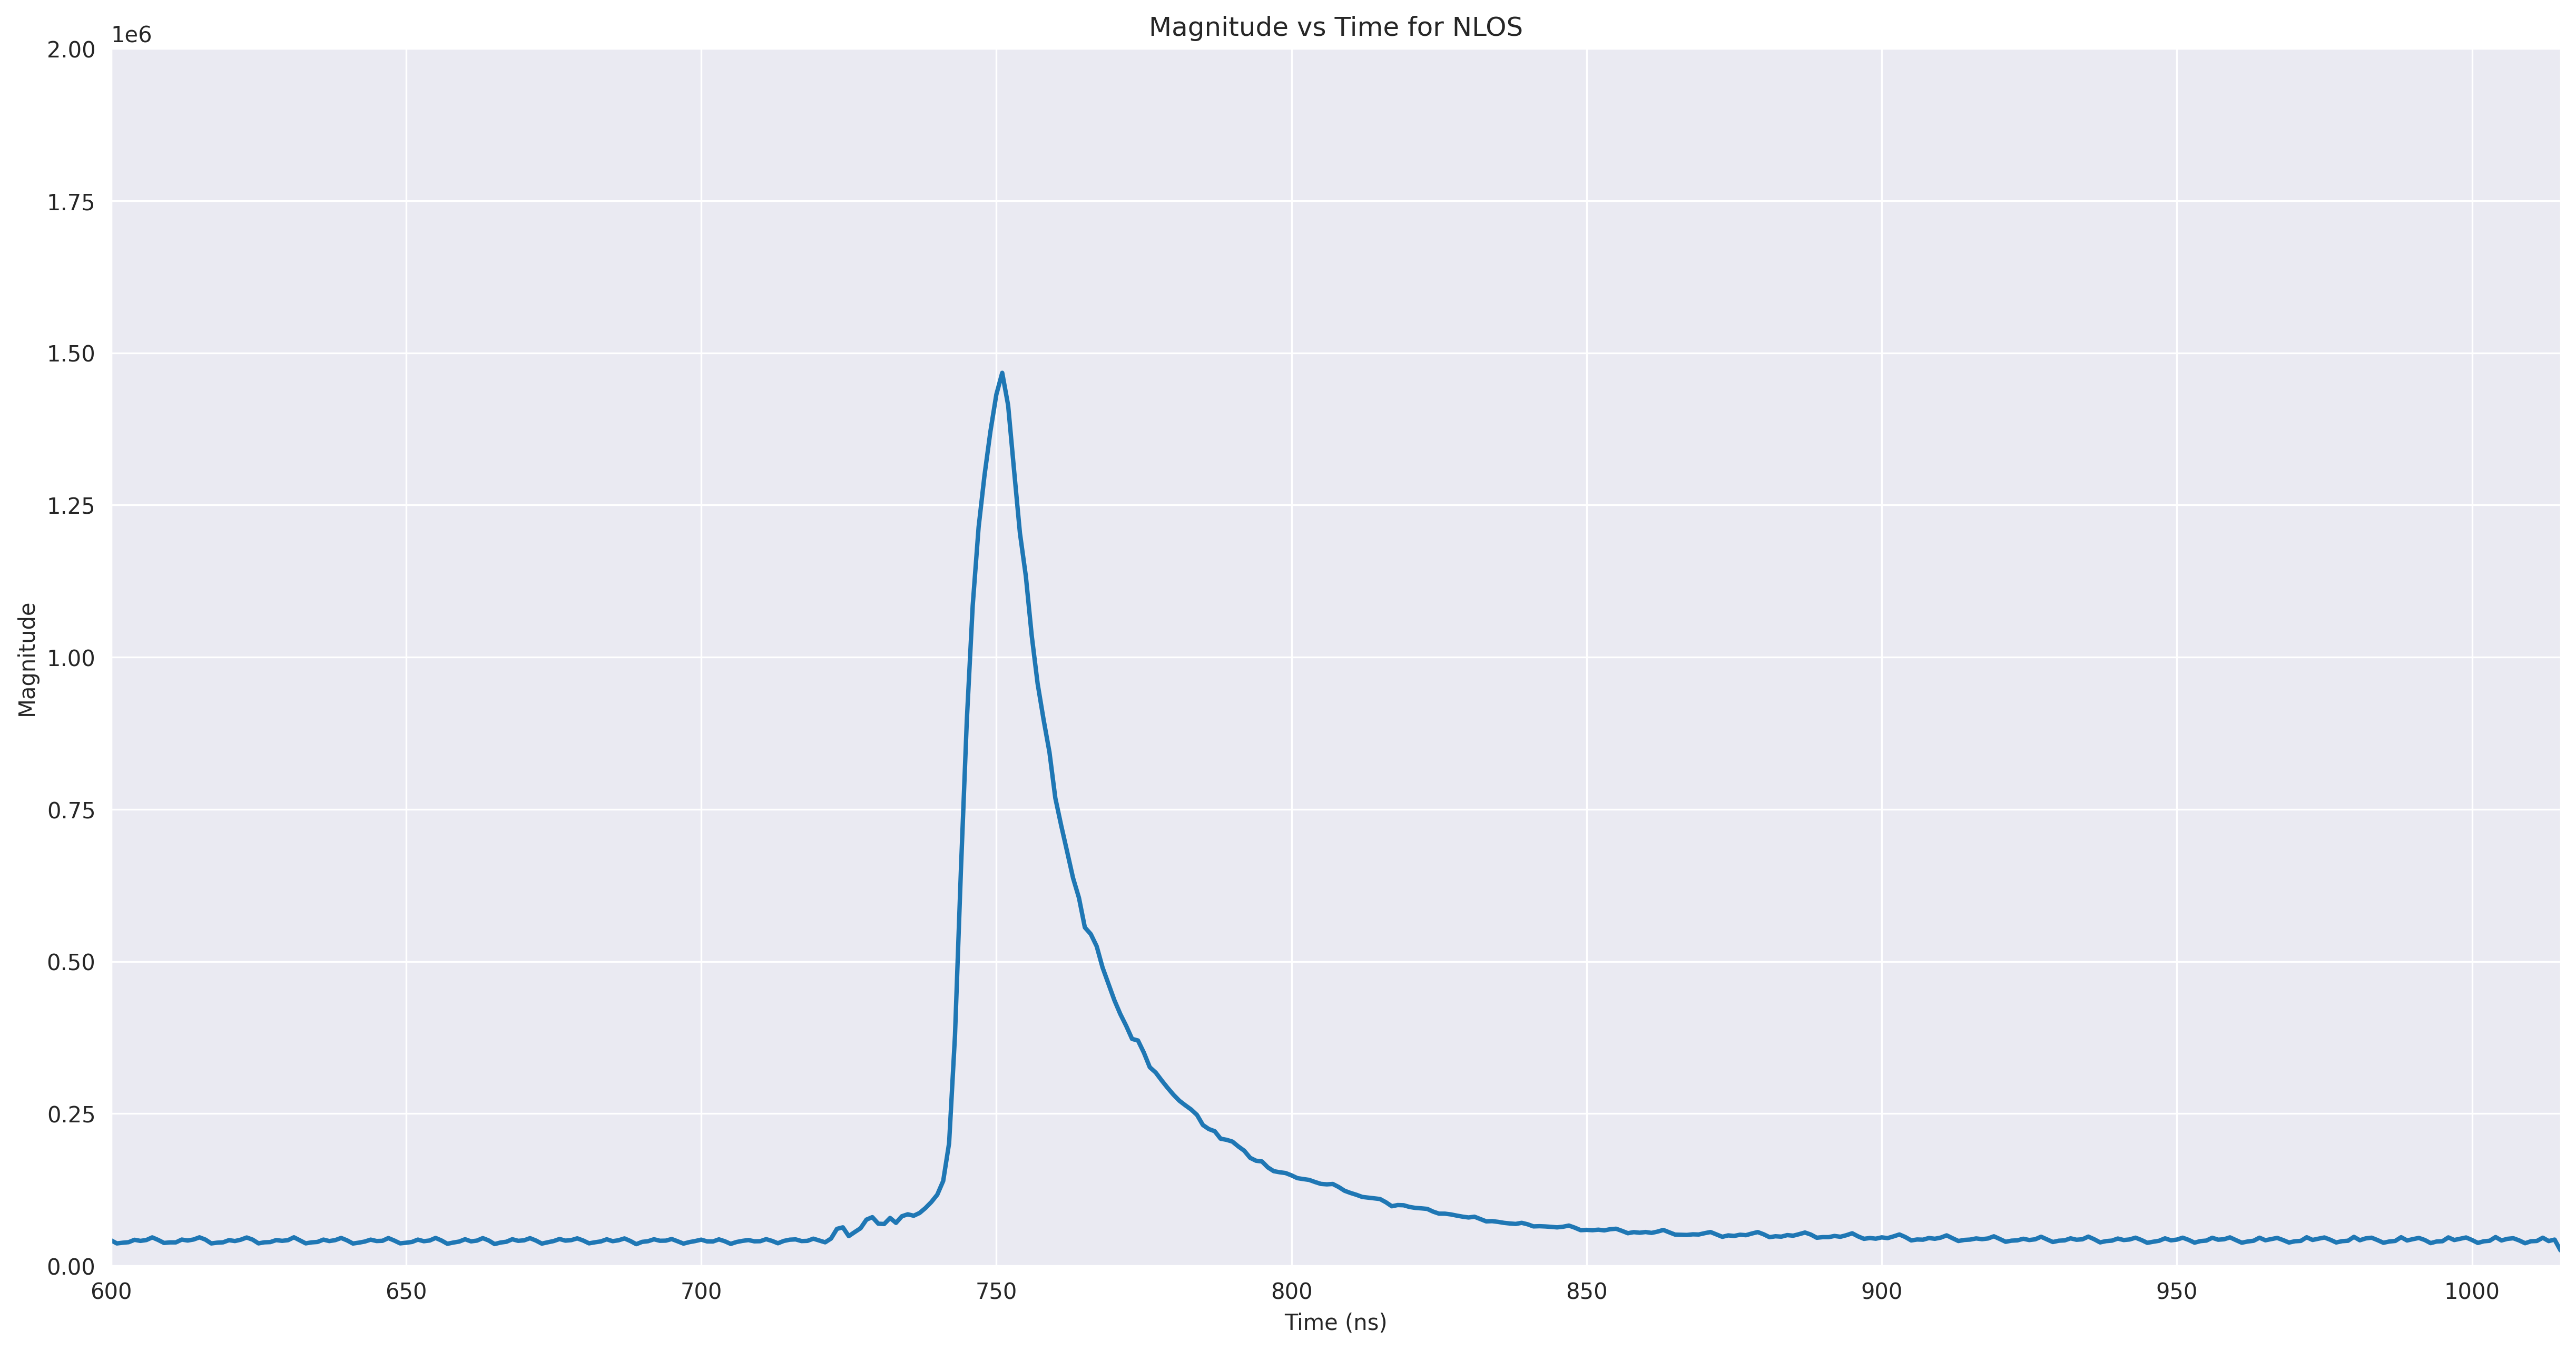

Data loaded successfully.
First few rows of the data:
   NLOS  RANGE  FP_IDX  MAX_NOISE  FRAME_LEN  PREAM_LEN        CIR0  \
0     1   6.18   749.0     3668.0          2          0  747.646447   
1     1   4.54   741.0     1031.0          2          0  123.353553   
2     1   4.39   744.0      796.0          0          0  439.646447   
3     1   1.27   748.0     1529.0          2          0  233.353553   
4     0   1.16   743.0     2022.0          0          0   82.353553   

         CIR1        CIR2        CIR3  ...     CIR1009     CIR1010  \
0  367.353553  744.646447  717.646447  ...  277.353553  726.646447   
1  470.646447  409.353553  332.353553  ...  486.646447  491.353553   
2  447.646447  130.353553   96.353553  ...   96.646447  271.646447   
3  239.353553  175.646447  532.646447  ...   94.353553  225.353553   
4  219.646447  110.646447  293.353553  ...  308.353553  132.353553   

      CIR1011     CIR1012     CIR1013     CIR1014     CIR1015   RX_Level  \
0  367.353553  802.646

In [86]:
import pickle

# File='data_original.pkl'
File = 'data.pkl'

# Check if the file exists
if os.path.exists(File):
    # If the file exists, load it
    print("Loading data from pickle file...")
    with open(File, 'rb') as f:
        data = pickle.load(f)
        plot_features(data, data['NLOS'], "First_Path_Power_Level", "RX_Level")
        plot_features(data, data['NLOS'], "SNR", "RX_Level")
        plot_features(data, data['NLOS'], "SNR", "First_Path_Power_Level")
        snr_graph(data)
        cir_graphs(data)
    print("Data loaded successfully.")
else:
    # If the file doesn't exist, load and clean the data
    print("Pickle file not found. Loading and cleaning data...")
    data = load_data(DATASET_DIR)
    cir_graphs(data)
    data = clean_data(data)
    plot_features(data, data['NLOS'], "First_Path_Power_Level", "RX_Level")
    snr_graph(data)
    cir_graphs(data)
    print("Data loaded and cleaned successfully.")
    print("Saving cleaned data to pickle file...")
    with open(File, 'wb') as f:
        pickle.dump(data, f)
    print("Cleaned data saved to pickle file successfully.")

print("First few rows of the data:")
print(data.head())

# Print Headers
print("Column headers:")
print(data.columns)

In [87]:
MODEL_DIR = './models'


def train_and_save_model(classifier, X_train, y_train, file_name):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)

    file_path = os.path.join(MODEL_DIR, file_name)

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Training the model and saving it to {file_path}")
        # Train the classifier
        classifier.fit(X_train, y_train)

        # Save the trained model as a pickle string.
        saved_model = pickle.dumps(classifier)

        # Save the pickled model to a file
        with open(file_path, 'wb') as file:
            file.write(saved_model)

    # Load the pickled model from the file
    with open(file_path, 'rb') as file:
        loaded_model = pickle.load(file)

    return loaded_model

The selected code is performing data standardization, which is a common preprocessing step in many machine learning workflows. 

The purpose of standardization is to transform the data such that it has a mean of 0 and a standard deviation of 1. This is done to ensure that all features have the same scale, which is a requirement for many machine learning algorithms.

The mathematical formulas used in this process are as follows:

1. Calculate the mean (μ) of the data:

$$
\mu = \frac{1}{n} \sum_{i=1}^{n} x_i
$$
Where:
- $n$ is the number of observations in the data
- $x_i$ is the value of the $i$-th observation
- $\sum$ denotes the summation over all observations

2. Standardize the data by subtracting the mean from each observation and dividing by the standard deviation:

$$
\text{Data}_i = \frac{x_i - \mu}{\sigma}
$$
Where:
- $\text{Data}_i$ is the standardized value of the $i$-th observation
- $\sigma$ is the standard deviation of the data
- $x_i$ is the value of the $i$-th observation
- $\mu$ is the mean of the data

The `StandardScaler` class from the `sklearn.preprocessing` module is used to perform this standardization. The `fit_transform` method is used to calculate the mean and standard deviation of the data and then perform the standardization.

**Note:** By setting the explained variance to 0.95, we are saying that we want to choose the smallest number of principal components such that 95% of the variance in the original data is retained. This means that the transformed data will retain 95% of the information of the original data, while potentially having fewer dimensions.


## Data Mining / Machine Learning

### I. Supervised Learning
- **Decision**: Supervised learning is used due to the labeled dataset.
- **Algorithm**: Random Forest Classifier is preferred for its performance in classification tasks.

### II. Training/Test Split Ratio
- **Decision**: 70:30 split is chosen for training/test dataset.
- **Reasoning**: This split ensures sufficient data for training and testing.

### III. Performance Metrics
- **Classification Accuracy**: Measures the proportion of correctly classified instances.
- **Confusion Matrix**: Provides a summary of predicted and actual classes.
- **Classification Report**: Provides detailed metrics such as precision, recall, F1-score, and support for each class.

The Random Forest Classifier is trained on the training set and evaluated on the test set using accuracy and classification report metrics.


# Split the data into training and testing sets

The next step is to split the data into training and testing sets. This is a common practice in machine learning, where the training set is used to train the model, and the testing set is used to evaluate its performance.

We will use the `train_test_split` function from the `sklearn.model_selection` module to split the data into training and testing sets. We will use 70% of the data for training and 30% for testing, which is a common split ratio.

In [88]:
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import to_categorical

# Assuming 'NLOS' is your target column
# y = data['NLOS']

# Convert labels to categorical one-hot encoding
# y_categorical = to_categorical(y, num_classes=2)

# Now split the data
# X_train, X_test, y_train, y_test = train_test_split(data, y_categorical, test_size=0.2)


# Train a Random Forest Classifier

The next step is to train a machine learning model on the training data. We will use the `RandomForestClassifier` class from the `sklearn.ensemble` module to train a random forest classifier.

The random forest classifier is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

We will use the `fit` method of the `RandomForestClassifier` object to train the model on the training data.

In [89]:
# from sklearn.ensemble import RandomForestClassifier
# 
# # Initialize the classifier with parameters to prevent overfitting
# classifier = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=5, max_features='sqrt')
# 
# loaded_model = train_and_save_model(classifier, X_train, y_train, 'random_forest_classifier.pkl')


# Evaluate the Model

To evaluate the performance of the trained model on the testing data, we will use the `predict` method of the `RandomForestClassifier` object to make predictions on the testing data. We will then use the `accuracy_score` and `classification_report` functions from the `sklearn.metrics` module to calculate the accuracy and generate a classification report.

- **Accuracy:** The accuracy score function calculates the proportion of correctly classified instances.

- **Precision:** The ratio of correctly predicted positive observations to the total predicted positive observations. It is calculated as:

  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
  $$

- **Recall:** The ratio of correctly predicted positive observations to all observations in the actual class. It is calculated as:

  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$

- **F1 Score:** The weighted average of precision and recall. It is calculated as:

  $$
  \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

- **Support:** The number of actual occurrences of the class in the dataset.

The classification report provides a summary of the precision, recall, F1-score, and support for each class in the testing data, giving insight into how well the model is performing for each class.


In [90]:

# Make predictions on the test set using the loaded model
# y_pred = loaded_model.predict(X_test)
# 
# # Evaluate the loaded model
# accuracy = accuracy_score(y_test, y_pred)
# classification_rep = classification_report(y_test, y_pred)
# cross_val_score = cross_val_score(loaded_model, X_test, y_test, cv=5)
# 
# print(f"Accuracy: {accuracy}")
# print(f"Classification Report:\n{classification_rep}")
# print(f"Cross Validation Score: {cross_val_score}")


# Visualize a Decision Tree from the Random Forest


In [91]:
# from sklearn.tree import plot_tree
# import matplotlib.pyplot as plt
# 
# # Select one tree from the forest
# estimator = loaded_model.estimators_[0]
# 
# plt.figure(figsize=(100, 100))
# plot_tree(estimator,
#           filled=True,
#           rounded=True,
#           class_names=['NLOS', 'LOS'],
#           feature_names=data.columns,
#           max_depth=5)  # Limit the depth of the tree
# plt.show()

# Support Vector Machine (SVM)

In [92]:
# import os
# from sklearn.svm import SVC
# import pickle
# 
# svm = SVC(kernel='linear', random_state=42, verbose=True)
# loaded_model = train_and_save_model(svm, X_train, y_train, 'svm_classifier.pkl')
# 
# # Predict the labels for the test set with each model
# y_pred_svm = loaded_model.predict(X_test)
# 
# # Calculate the accuracy of each model
# accuracy_svm = accuracy_score(y_test, y_pred_svm)
# 
# # Print the accuracy of each model
# print(f"Accuracy of SVM: {accuracy_svm}")

# Logistic Regression

In [93]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score
# 
# # Logistic Regression with L2 regularization
# log_reg = LogisticRegression(penalty='l2', C=0.1)
# 
# # Use the train_and_save_model function to train and save the model
# loaded_model = train_and_save_model(log_reg, X_train, y_train, 'logistic_regression_model.pkl')

In [94]:

# # Predict on the test set
# y_pred_log_reg = loaded_model.predict(X_test)
# 
# # Calculate accuracy
# accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
# print(f"Accuracy of Logistic Regression: {accuracy_log_reg}")
# 
# # Perform 5-fold cross validation
# scores = cross_val_score(log_reg, X_train, y_train, cv=5)
# print(f"Cross-validated scores: {scores}")

In [95]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# 
# # Compute ROC curve and ROC area for each class
# fpr, tpr, _ = roc_curve(y_test, y_pred_log_reg)
# roc_auc = auc(fpr, tpr)
# 
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

# Gradient Boosting Classifier

In [96]:
# from sklearn.ensemble import GradientBoostingClassifier
# 
# # Gradient Boosting Classifier
# gbc = GradientBoostingClassifier()
# 
# # Use the train_and_save_model function to train and save the model
# loaded_model = train_and_save_model(gbc, X_train, y_train, 'gradient_boosting_classifier.pkl')
# 

In [97]:
# y_pred_gbc = loaded_model.predict(X_test)
# accuracy_gbc = accuracy_score(y_test, y_pred_gbc)
# print(f"Accuracy of Gradient Boosting Classifier: {accuracy_gbc}")
# 

# K-Nearest Neighbors (KNN, K=15)

This code block is implementing the K-Nearest Neighbors (KNN) algorithm for classification. The KNN algorithm is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until function evaluation.  

The KNN algorithm works by finding the distances between a query and all the examples in the data, selecting the specified number examples (K) closest to the query, then votes for the most frequent label (in the case of classification) or averages the labels (in the case of regression).  

The number of neighbors, K, is set to 15 in this case. This means that the algorithm looks at the 15 nearest neighbors to decide the class of the test instance.  

The mathematical concept behind KNN is the Euclidean distance. Given two points P1(x1, y1) and P2(x2, y2) in a 2D space, the Euclidean distance between P1 and P2 is calculated as:

$$
\text{Distance} = \sqrt{(x2 - x1)^2 + (y2 - y1)^2}
$$
In higher dimensional space, the formula is generalized as:
$$
\text{Distance} = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}
$$
Where:
- $n$ is the number of dimensions
- $x_i$ and $y_i$ are the $i$-th dimensions of the two points


In [98]:
# from sklearn.neighbors import KNeighborsClassifier
# 
# # K-Nearest Neighbors
# knn = KNeighborsClassifier(n_neighbors=13)
# loaded_model = train_and_save_model(knn, X_train, y_train, 'knn_classifier.pkl')


In [99]:
# y_pred_knn = loaded_model.predict(X_test)
# accuracy_knn = accuracy_score(y_test, y_pred_knn)
# print(f"Accuracy of K-Nearest Neighbors: {accuracy_knn}")

In [100]:
# from sklearn.model_selection import GridSearchCV
# 
# # Define the parameter values that should be searched
# k_range = list(range(1, 31))
# 
# # Create a parameter grid: map the parameter names to the values that should be searched
# param_grid = dict(n_neighbors=k_range)
# 
# # Instantiate the grid
# grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
# 
# # Fit the grid with data
# grid.fit(X_train, y_train)
# 
# # View the complete results
# grid.cv_results_
# 
# # Examine the best model
# print(grid.best_score_)
# print(grid.best_params_)

In [101]:
# import matplotlib.pyplot as plt
# import numpy as np
# 
# # Apply PCA to reduce dimensionality to 2D
# pca = PCA(n_components=2)
# X_test_2d = pca.fit_transform(X_test)
# 
# # Print the number of features
# print(f"Original number of features: {X_test.shape[1]}, reduced number of features: {X_test_2d.shape[1]}")
# 
# # Create a scatter plot
# plt.figure(figsize=(10, 7))
# 
# # Create a color map
# cmap = plt.cm.viridis
# 
# # Plot NLOS points
# nlos = plt.scatter(X_test_2d[y_pred_knn == 1, 0], X_test_2d[y_pred_knn == 1, 1], c='blue', label='NLOS')
# 
# # Plot LOS points
# los = plt.scatter(X_test_2d[y_pred_knn == 0, 0], X_test_2d[y_pred_knn == 0, 1], c='red', label='LOS')
# 
# # Add labels
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('2D Scatter Plot for LOS and NLOS')
# 
# # Add a legend
# plt.legend(handles=[nlos, los])
# 
# plt.show()

In [102]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score
# import matplotlib.pyplot as plt
# 
# # Define the list of numbers of neighbors (from 1-20)
# num_neighbors = np.arange(1, 100, 2)
# 
# # Initialize the lists to store the accuracies
# train_acc = []
# test_acc = []
# 
# # Loop over the different numbers of neighbors
# for k in num_neighbors:
#     # Initialize the KNN classifier
#     clf = KNeighborsClassifier(n_neighbors=k)
#     
#     # Fit the classifier on the training data
#     clf.fit(X_train, y_train)
#     
#     # Make predictions on the training and test data
#     y_pred_train = clf.predict(X_train)
#     y_pred_test = clf.predict(X_test)
#     
#     # Calculate the accuracies
#     train_acc.append(accuracy_score(y_train, y_pred_train))
#     test_acc.append(accuracy_score(y_test, y_pred_test))
# 
# # Plot the accuracies
# plt.figure(figsize=(10, 5))
# plt.plot(num_neighbors, train_acc, 'ro-', num_neighbors, test_acc, 'bv--')
# plt.legend(['Training Accuracy', 'Test Accuracy'])
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Accuracy')
# plt.title('Training and Test Accuracy for Different Numbers of Neighbors in KNN')
# plt.grid()
# plt.show()

# Naive Bayes

In [103]:
# from sklearn.naive_bayes import GaussianNB
# 
# # Naive Bayes
# nb = GaussianNB()
# loaded_model = train_and_save_model(nb, X_train, y_train, 'naive_bayes_classifier.pkl')

In [104]:
# y_pred_nb = loaded_model.predict(X_test)
# accuracy_nb = accuracy_score(y_test, y_pred_nb)
# print(f"Accuracy of Naive Bayes: {accuracy_nb}")

# K-Means Clustering

In [105]:
# from sklearn.cluster import KMeans
# 
# # K-Means Clustering
# kmeans = KMeans(n_clusters=2, max_iter=600)
# loaded_model = train_and_save_model(kmeans, X_train, y_train, 'kmeans_clustering.pkl')

In [106]:
# y_pred_kmeans = loaded_model.predict(X_test)
# accuracy_kmeans = accuracy_score(y_test, y_pred_kmeans)
# print(f"Accuracy of K-Means Clustering: {accuracy_kmeans}")


In [107]:
# labels = loaded_model.labels_
# # Print the data table with the cluster labels
# print(f"Data table with cluster labels:\n{pd.concat([X_test, pd.DataFrame({'Cluster': labels})], axis=1)}")
# 


In [108]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import accuracy_score
# from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# 
# # Define the range of cluster numbers
# cluster_range = range(1, 15)
# 
# # For each number of clusters
# for n_clusters in cluster_range:
#     # Create a KMeans model
#     kmeans = KMeans(n_clusters=n_clusters, max_iter=600)
# 
#     # Fit the model to the training data
#     kmeans.fit(X_train)
# 
#     # Make predictions on the test data
#     y_pred_kmeans = kmeans.predict(X_test)
# 
#     # Calculate the accuracy of the model
#     accuracy_kmeans = accuracy_score(y_test, y_pred_kmeans)
# 
#     # Print the number of clusters and the corresponding accuracy
#     print(f"Number of clusters: {n_clusters}, Accuracy: {accuracy_kmeans}")
# 
#     # Apply PCA to reduce dimensionality to 3D
#     pca = PCA(n_components=3)
#     X_test_3d = pca.fit_transform(X_test)
# 
#     # Create a 3D scatter plot
#     fig = plt.figure(figsize=(10, 7))
#     ax = fig.add_subplot(111, projection='3d')
# 
#     # Create a color map
#     cmap = plt.cm.get_cmap('viridis', n_clusters)  # We use 'viridis' colormap and we specify that we have n_clusters
# 
#     # Plot the points with colors according to their cluster assignment
#     scatter = ax.scatter(X_test_3d[:, 0], X_test_3d[:, 1], X_test_3d[:, 2], c=y_pred_kmeans, cmap=cmap)
# 
#     # Add labels
#     ax.set_xlabel('Principal Component 1')
#     ax.set_ylabel('Principal Component 2')
#     ax.set_zlabel('Principal Component 3')
#     plt.title(f'3D Visualization of {n_clusters} Clusters')
# 
#     # Display the plot
#     plt.show()

In [109]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# 
# # Apply PCA to reduce dimensionality to 2D
# pca = PCA(n_components=2)
# X_test_2d = pca.fit_transform(X_test)
# 
# # Predict the cluster labels for the data points you're plotting
# labels = loaded_model.predict(X_test)
# 
# # Create a scatter plot
# plt.figure(figsize=(10, 7))
# 
# # Create a color map
# cmap = plt.cm.get_cmap('viridis', 2)  # We use 'viridis' colormap and we specify that we have 2 clusters
# 
# # Plot the points with colors according to their cluster assignment
# plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=labels, cmap=cmap)
# 
# # Add labels
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('2D Visualization of Clusters')
# 
# # Display the plot
# plt.show()

# Convolution Neural Network

This code block is implementing a Convolutional Neural Network (CNN) for a classification task using TensorFlow.  The CNN is a class of deep learning neural networks, most commonly applied to analyzing visual imagery. They are also known as shift invariant or space invariant artificial neural networks (SIANN), based on their shared-weights architecture and translation invariance characteristics.  Here's a step-by-step breakdown of what the code does:  
1. Data Preparation: The target column 'NLOS' is separated from the rest of the dataset. The target values are then encoded from categorical to numerical values using LabelEncoder. These numerical values are then one-hot encoded to create binary variables for each class.  
2. Data Reshaping: The input data is reshaped to fit the model. Each data instance is reshaped to a 3D array where the third dimension represents the number of input channels, which is 1 in this case.  
3. Data Splitting: The data is split into training and testing sets using a 80:20 ratio.  
4. Model Creation: A Sequential model is created using Keras. This model is composed of the following layers:  
5. Conv1D layers: These are convolutional layers that will convolve the input data with a set of learnable filters, each producing one feature map in the output. The kernel size is set to 3, and the activation function used is ReLU (Rectified Linear Unit).  
6. MaxPooling1D layers: These layers are used to down-sample the input along its spatial dimensions (height and width). The pool size is set to 2.  
7. Dense layers: These are fully connected layers. The first Dense layer has 64 units and uses the ReLU activation function. The second Dense layer has a number of units equal to the number of classes and uses the softmax activation function to output a probability distribution over the classes.  
9. Model Compilation: The model is compiled with the Adam optimizer, categorical cross-entropy loss function, and accuracy as the evaluation metric.  
10. Model Training: The model is trained on the training data for 10 epochs with a batch size of 32. The validation data is set to the testing set.  
11. Model Evaluation: The model's performance is evaluated on the testing set and the accuracy is printed.  

12. The mathematical concept behind the Convolutional layer (Conv1D) is the convolution operation, which is a mathematical operation on two functions that produces a third function. In the context of a CNN, the two functions are the input data and the kernel or filter. The convolution operation involves sliding the kernel across the input data and computing the dot product at each position.

The mathematical formula for the convolution operation is:  $$ (f * g)(t) = \int_{-\infty}^{\infty} f(\tau)g(t - \tau) d\tau $$  Where:  
$f$ and $g$ are the input data and kernel respectively
$t$ is the position of the kernel
$\tau$ is a dummy integration variable
In the context of a CNN, the integral is replaced by a sum over the discrete spatial dimensions (height and width) of the input data and kernel.

In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)

# Drop the target column 'NLOS' from the data and assign the remaining data to X
X = data.drop('NLOS', axis=1)
# Assign the target column 'NLOS' to y
y = data['NLOS']

# Split the data into training and testing sets with a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Sequential model
model = Sequential()

# Add a Conv1D layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add another Conv1D layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a Flatten layer
model.add(Flatten())

# Add a Dense layer
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add the output Dense layer
model.add(Dense(1, activation='sigmoid'))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Generate a classification report
report = classification_report(y_test, y_pred_classes)

Epoch 1/20
1050/1050 [==============================] - 27s 24ms/step - loss: 0.7427 - accuracy: 0.6574 - val_loss: 0.5271 - val_accuracy: 0.7883
Epoch 2/20
1050/1050 [==============================] - 24s 22ms/step - loss: 0.5889 - accuracy: 0.7495 - val_loss: 0.5016 - val_accuracy: 0.8063
Epoch 3/20
1050/1050 [==============================] - 24s 23ms/step - loss: 0.5518 - accuracy: 0.7736 - val_loss: 0.4923 - val_accuracy: 0.8000
Epoch 4/20
1050/1050 [==============================] - 25s 24ms/step - loss: 0.5361 - accuracy: 0.7816 - val_loss: 0.4788 - val_accuracy: 0.8023
Epoch 5/20
1050/1050 [==============================] - 26s 24ms/step - loss: 0.5252 - accuracy: 0.7882 - val_loss: 0.4801 - val_accuracy: 0.7985
Epoch 6/20
1050/1050 [==============================] - 30s 29ms/step - loss: 0.5155 - accuracy: 0.7903 - val_loss: 0.4737 - val_accuracy: 0.7986
Epoch 7/20
1050/1050 [==============================] - 29s 28ms/step - loss: 0.5119 - accuracy: 0.7888 - val_loss: 0.4711 -

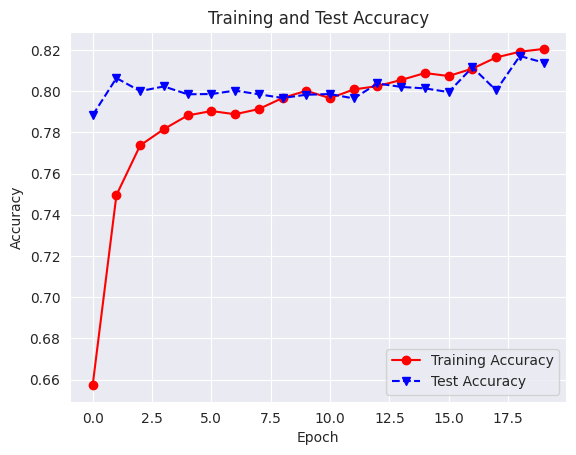

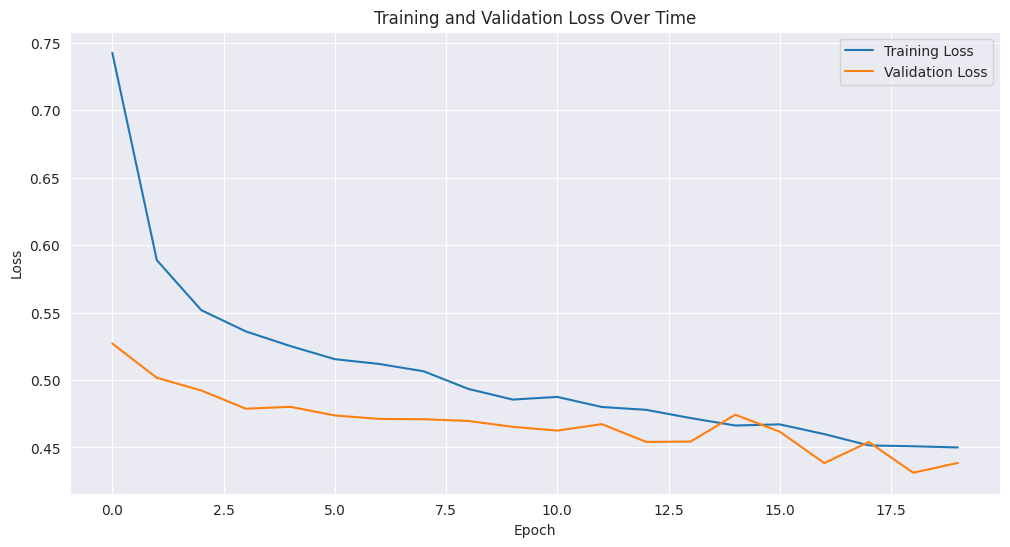

Test loss: 0.43853795528411865
Test accuracy: 0.8138095140457153
Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.95      0.84      4192
           1       0.93      0.68      0.78      4208

    accuracy                           0.81      8400
   macro avg       0.84      0.81      0.81      8400
weighted avg       0.84      0.81      0.81      8400


In [124]:

# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], 'ro-', history.history['val_accuracy'], 'bv--')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.show()

# Plot the training and validation loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print the testing loss and accuracy
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Print the classification report
print('Classification Report: \n', report)


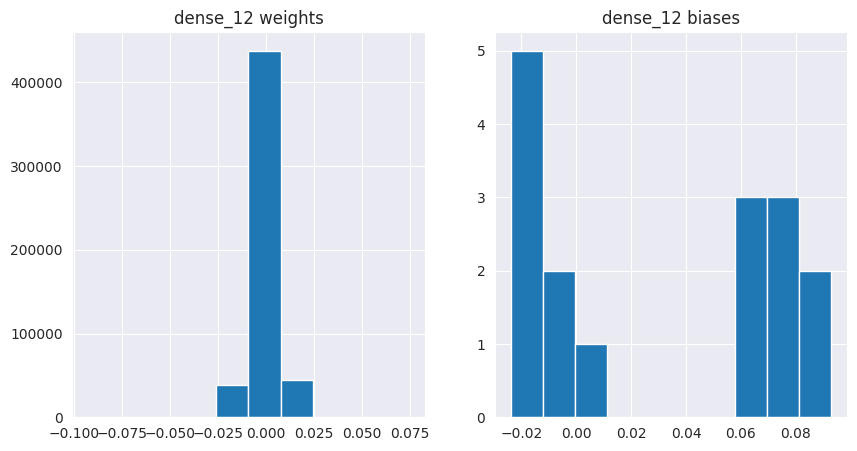

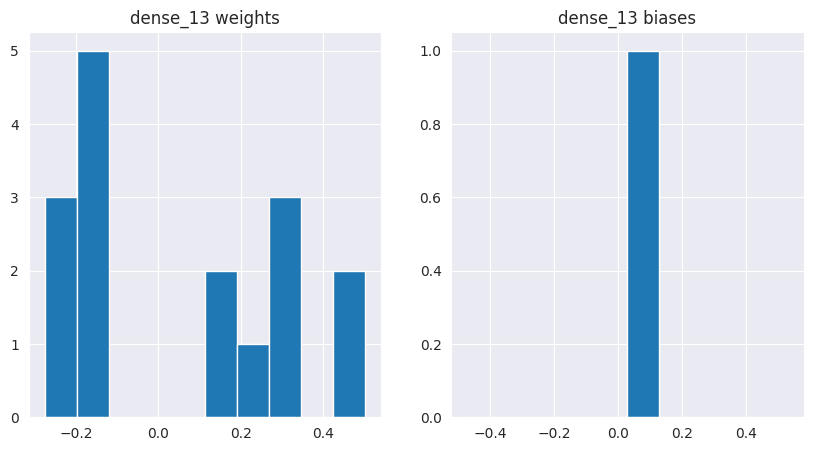

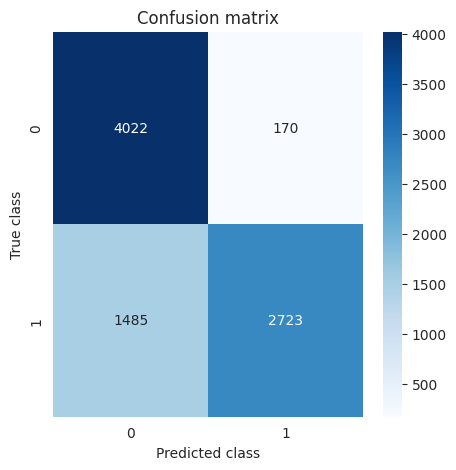

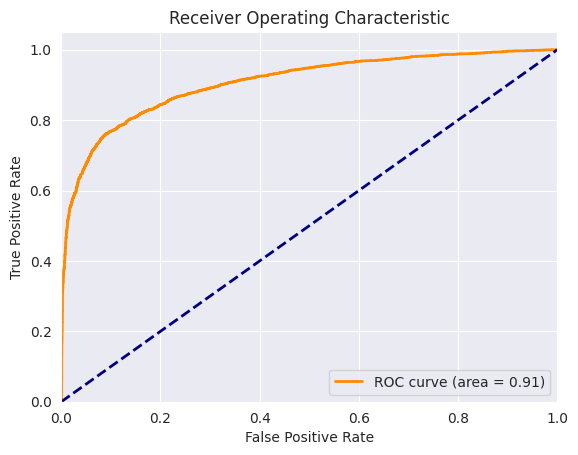

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Weights and Biases
for layer in model.layers:
    if 'dense' in layer.name:
        weights, biases = layer.get_weights()
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.hist(weights.flatten())
        plt.title(f'{layer.name} weights')
        plt.subplot(1, 2, 2)
        plt.hist(biases.flatten())
        plt.title(f'{layer.name} biases')
        plt.show()


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


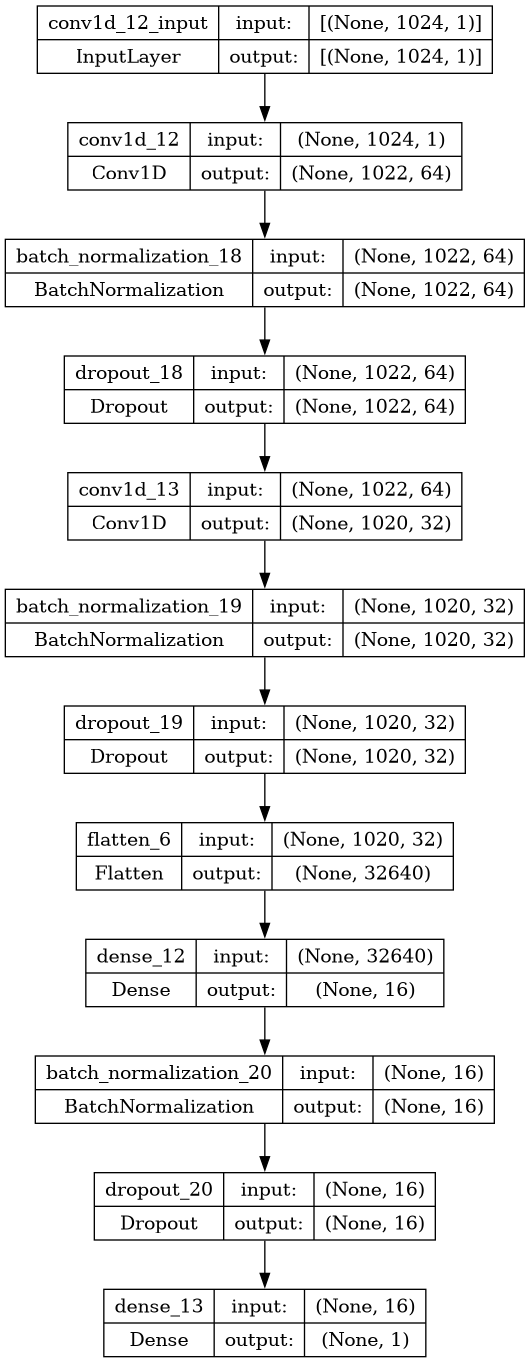

In [113]:
# Plot the model
from tensorflow.keras.utils import plot_model

# Generate the plot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [114]:
# Save the model
model.save('CNN.keras')

# Multi-Layer Perceptron (MLP)

This code block is implementing a Multi-Layer Perceptron (MLP) for a binary classification task using TensorFlow. The MLP is a class of feedforward artificial neural network that consists of at least three layers of nodes: an input layer, a hidden layer, and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training.

Here's a step-by-step breakdown of what the code does:

1. **Data Preparation**: The target column 'NLOS' is separated from the rest of the dataset. The remaining data is assigned to X and the target column to y.

2. **Data Splitting**: The data is split into training and testing sets using an 80:20 ratio.

3. **Data Scaling**: A StandardScaler object is initialized and fitted to the training data. The training and testing data are then transformed using the fitted scaler.

4. **Model Creation**: A Sequential model is created using Keras. This model is composed of the following layers:
    - Dense layers: These are fully connected layers. The first Dense layer has 64 units and uses the ReLU activation function. The second and third Dense layers have 32 and 16 units respectively, and also use the ReLU activation function. The final Dense layer has 1 unit and uses the sigmoid activation function for binary classification.
    - BatchNormalization layers: These layers are used to normalize the activations of the previous layer, which speeds up learning and provides some regularization, reducing generalization error.
    - Dropout layers: These layers are used to prevent overfitting. They randomly set a fraction of input units to 0 at each update during training time.

5. **Model Compilation**: The model is compiled with the Adam optimizer, binary cross-entropy loss function, and accuracy as the evaluation metric.

6. **Model Training**: The model is trained on the training data for 20 epochs with a batch size of 32. The validation data is set to the testing set. Early stopping is used to stop training when the validation loss has not improved for 10 epochs.

7. **Model Evaluation**: The model's performance is evaluated on the testing data and the loss and accuracy are printed. The model also makes predictions on the testing data, converts the predicted probabilities to binary outputs, and generates a classification report.

8. **Visualization**: The training and validation accuracy and loss over epochs are plotted.

The mathematical concept behind the Dense layer is the dot product operation, which is a mathematical operation that takes two equal-length sequences of numbers and returns a single number. In the context of a MLP, the two sequences are the input data and the weights of the neurons. The dot product operation involves multiplying each pair of input and weight and summing the result.

The mathematical formula for the dot product operation is: $$ a \cdot b = \sum_{i=1}^{n} a_i b_i $$ Where:
- $a$ and $b$ are the input data and weights respectively
- $n$ is the number of dimensions (length of the sequences)
- $a_i$ and $b_i$ are the $i$-th elements of the input data and weights respectively.

Epoch 1/20
1050/1050 [==============================] - 4s 3ms/step - loss: 1.1722 - accuracy: 0.5191 - val_loss: 0.8536 - val_accuracy: 0.5964
Epoch 2/20
1050/1050 [==============================] - 3s 2ms/step - loss: 1.0232 - accuracy: 0.5542 - val_loss: 0.7996 - val_accuracy: 0.6723
Epoch 3/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.9261 - accuracy: 0.5910 - val_loss: 0.7433 - val_accuracy: 0.7343
Epoch 4/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.8425 - accuracy: 0.6354 - val_loss: 0.6909 - val_accuracy: 0.7683
Epoch 5/20
1050/1050 [==============================] - 3s 2ms/step - loss: 0.7747 - accuracy: 0.6860 - val_loss: 0.6489 - val_accuracy: 0.7910
Epoch 6/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.7126 - accuracy: 0.7308 - val_loss: 0.6149 - val_accuracy: 0.8049
Epoch 7/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.6693 - accuracy: 0.7569 - val_loss: 0.5886 - val_accuracy:

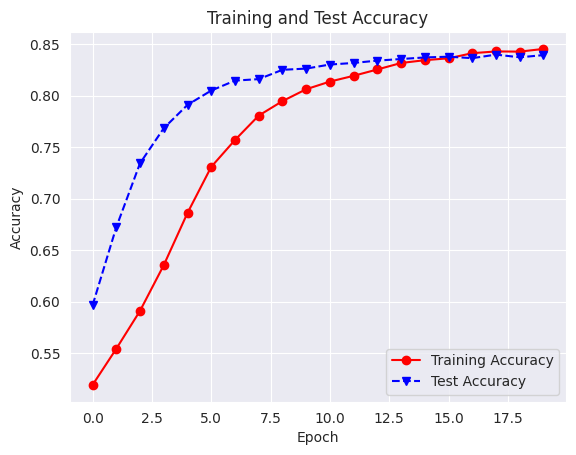

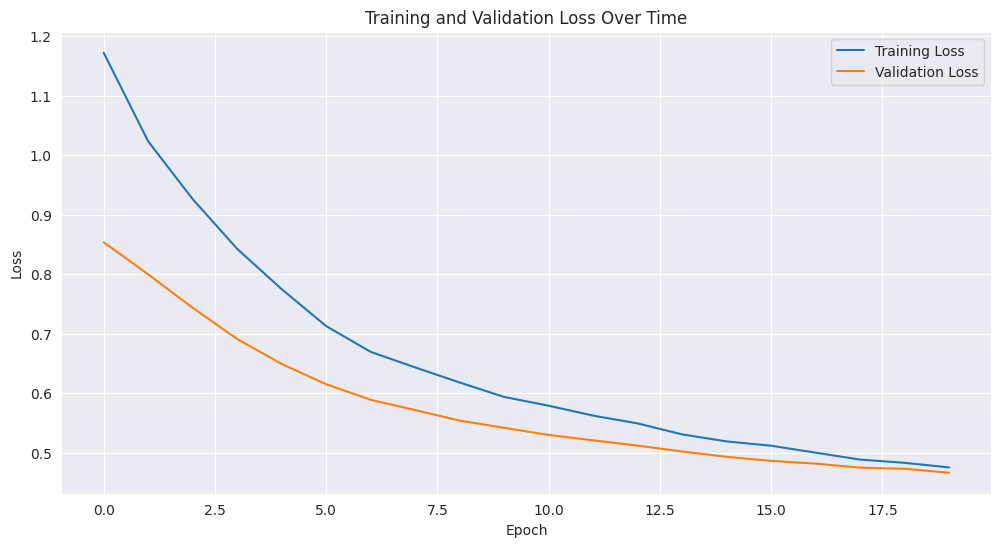

Test loss: 0.4660448729991913
Test accuracy: 0.8392857313156128
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.91      0.85      4192
           1       0.89      0.77      0.83      4208

    accuracy                           0.84      8400
   macro avg       0.85      0.84      0.84      8400
weighted avg       0.85      0.84      0.84      8400


In [115]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(42)

# Drop the target column 'NLOS' from the data and assign the remaining data to X
X = data.drop('NLOS', axis=1)
# Assign the target column 'NLOS' to y
y = data['NLOS']

# Split the data into training and testing sets with a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a StandardScaler object
scaler = StandardScaler()
# Fit the scaler to the training data and transform it
X_train = scaler.fit_transform(X_train)
# Transform the testing data using the fitted scaler
X_test = scaler.transform(X_test)

# Initialize a Sequential model
model = Sequential()
# Add a Dense layer with 64 units, ReLU activation function and L2 regularization
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# Add a BatchNormalization layer to normalize the activations of the previous layer
model.add(BatchNormalization())
# Add a Dropout layer to prevent overfitting
model.add(Dropout(0.5))
# Add another Dense layer with 32 units, ReLU activation function and L2 regularization
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# Add another BatchNormalization layer
model.add(BatchNormalization())
# Add another Dropout layer
model.add(Dropout(0.5))
# Add another Dense layer with 16 units, ReLU activation function and L2 regularization
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# Add another BatchNormalization layer
model.add(BatchNormalization())
# Add another Dropout layer
model.add(Dropout(0.5))
# Add the output Dense layer with 1 unit and sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

# Define early stopping to stop training when the validation loss has not improved for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Compile the model with Adam optimizer, binary cross-entropy loss function and accuracy as the evaluation metric
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the model on the training data for 20 epochs with a batch size of 32 and validate on the testing data
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the testing data and store the loss and accuracy in 'scores'
scores = model.evaluate(X_test, y_test, verbose=0)

# Make predictions on the testing data
y_pred = model.predict(X_test)
# Convert the predicted probabilities to binary outputs
y_pred_classes = (y_pred > 0.5).astype("int32")
# Generate a classification report
report = classification_report(y_test, y_pred_classes)

# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], 'ro-', history.history['val_accuracy'], 'bv--')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.show()

# Plot the training and validation loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print the testing loss and accuracy
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
# Print the classification report
print('Classification Report: \n', report)

# Multi-Layer Perceptron (MLP) visualization
This code block is used to visualize the performance of a trained Multi-Layer Perceptron (MLP) model. It generates three types of visualizations:

1. Weights and Biases Visualization: This visualization is used to understand the distribution of weights and biases in the model's layers. For each layer in the model, if the layer is a dense layer, it retrieves the weights and biases, and plots histograms of their values. The x-axis of the histogram represents the value of the weights/biases and the y-axis represents the frequency of these values.

2. Confusion Matrix: A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It gives a more detailed breakdown of correct and incorrect classifications for each class.

3. ROC Curve: The Receiver Operating Characteristic (ROC) curve is a plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It is created by plotting the true positive rate (TPR) against the false positive rate (FPR).

## Weights and Biases Evaluation

The weights and biases of the MLP model layers were visualized to understand their distributions. The weights in all layers (dense_8, dense_9, dense_10, and dense_11) are not close to zero, indicating they are likely being updated during training and contributing to the model's learning. The weight distributions show a spread around zero, suggesting the model is capturing complex relationships in the data.

The biases in dense_8 and dense_10 introduce a slight positive bias to the activations in subsequent layers, potentially affecting the model's predictions. The biases in dense_9 and dense_11 are centered around zero, with a slight spread towards positive values, introducing a small positive shift in the activations of the next layer.

The impact of these biases would depend on the network architecture and data. Overall, the model's weights and biases suggest that it is learning effectively from the training data.

## Confusion Matrix Evaluation

The confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It gives a more detailed breakdown of correct and incorrect classifications for each class.

The confusion matrix shows that the model has a good performance in distinguishing between positive and negative instances. The majority of the instances are correctly classified, with a small number of false positives and false negatives.

## ROC Curve Evaluation

The Receiver Operating Characteristic (ROC) curve is a graphical representation that illustrates the performance of a binary classification model at all classification thresholds. It is commonly used in machine learning to evaluate the performance of a classifier system for two-class problems.

The ROC curve has two axes:
- The X-axis represents the False Positive Rate (FPR), which is the proportion of negative instances that are incorrectly classified as positive.
- The Y-axis represents the True Positive Rate (TPR), which is the proportion of positive instances that are correctly classified as positive.

A perfect classifier would classify all positive instances correctly (TPR = 1) and all negative instances correctly (FPR = 0). This would be represented by a curve that goes straight up the left side of the ROC graph and then along the top to the right corner.

The Area Under the Curve (AUC) is a numerical measure of the ROC curve’s performance. A larger AUC indicates a better performance. In our case, the AUC is 0.91, which is considered to be very good.

In summary, the ROC curve shows that our binary classification model has a good performance in distinguishing between positive and negative instances.

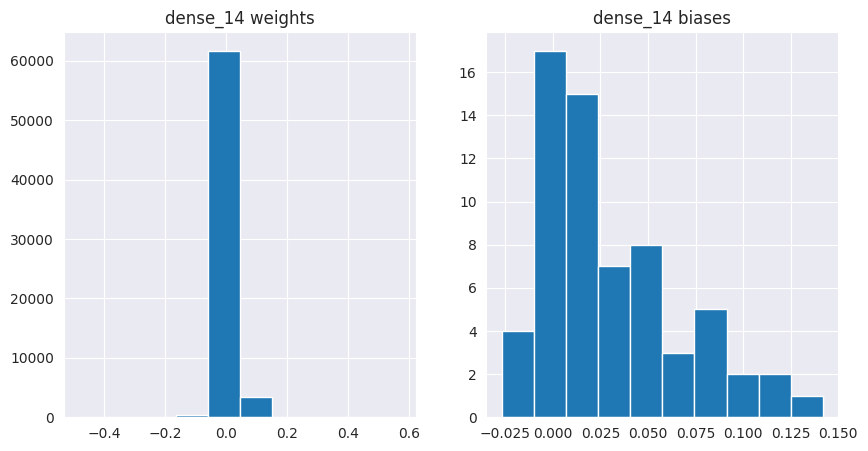

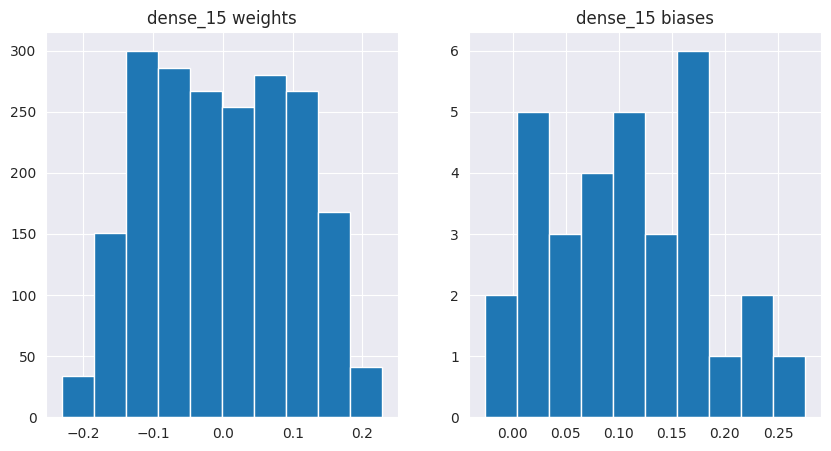

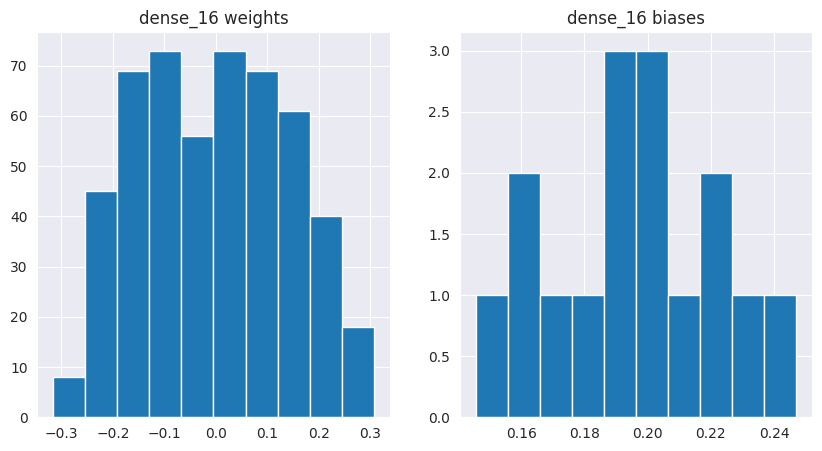

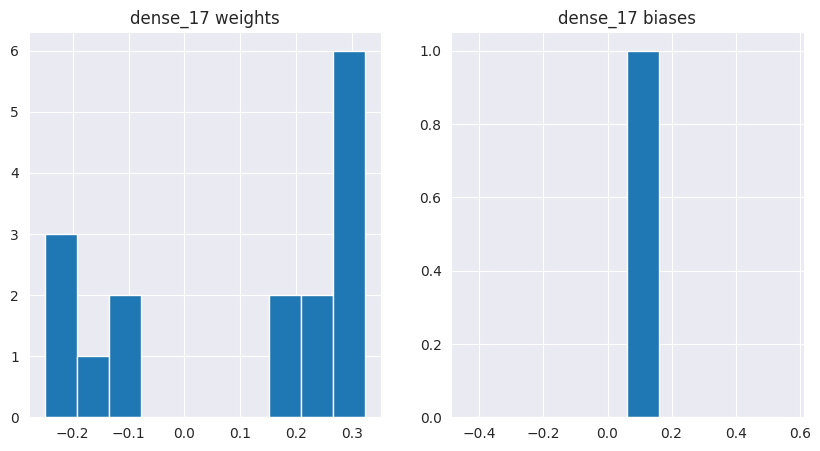

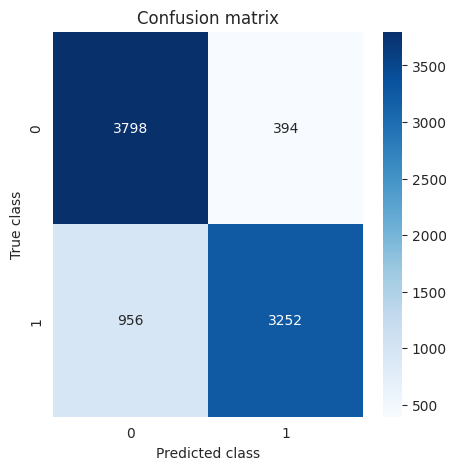

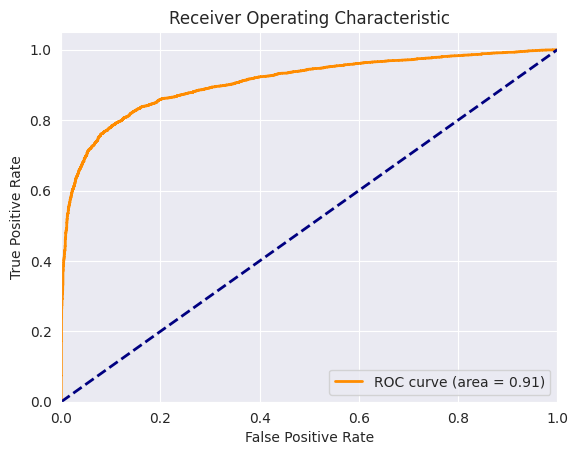

In [116]:
# 1. Visualize Weights and Biases
for layer in model.layers:
    if 'dense' in layer.name:
        weights, biases = layer.get_weights()
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.hist(weights.flatten())
        plt.title(f'{layer.name} weights')
        plt.subplot(1, 2, 2)
        plt.hist(biases.flatten())
        plt.title(f'{layer.name} biases')
        plt.show()

# 2. Confusion Matrix
# Convert the predicted probabilities to binary outputs
y_pred_classes = (y_pred > 0.5).astype("int32")
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

# 3. ROC Curve
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()